In [129]:

%%file kmeans_mc_numba.py
import numpy as np
import pandas as pd
import numba, math
from numba import jit
from pandas import DataFrame
from multiprocessing import Pool, cpu_count
from functools import partial


@jit
#distance square
def dist_sq(a, b):
    return np.sum((a-b)**2)


#minimum distance square for every point to the centroid
def point_sq(data,centroid):
    dist=[min(dist_sq(d,c) for c in centroid) for d in data]
    return dist
        
#calculate probability
def dist_prob_plus(Dist):
    return Dist/np.sum(Dist)

#calculate probability
def dist_prob_parallel(Dist,l):
    return l*Dist/np.sum(Dist)


#step 2: calculate the cost and number of iterations(log(cost))
def log_cost_mc(data_copy,centroid):
    pool = Pool(processes=cpu_count())
    # use partial function
    min_dist_sq = partial(point_sq,centroid)
    cost = np.sum(pool.map(min_dist_sq, data_copy))
    iteration=math.ceil(np.log(cost))
    pool.close()
    pool.terminate()
    return iteration

    
    
#calculate weights
#step 4: assign the weights
def weight_prob(data_copy, centroid):
    weight=[np.argmin(list(dist_sq(d,c) for c in centroid)) for d in data_copy]
    w=np.array([weight.count(i) for i in range(len(data_copy))])
    return w



#step 5: recluster the weighted points in C into k clusters
#reinitialize k centroids
def reassign_centroids(centroid,k,d,w):
    new_centroid=np.zeros([k,d])
    for cluster in range(k):
        #according to the weights from step 4, calculate the probability that a point is sampled from C
        prob_w=list(w/sum(w))
        #sample a new centroid
        new_index=np.random.choice(centroid.shape[0],1,prob_w)
        #store the new centroid
        new_centroid[cluster]=centroid[new_index]
        #delete the new centroid from the centroid
        centroid=np.delete(centroid,new_index,axis=0)
        #delete the correponding weight
        w=np.delete(w,new_index,axis=0)
    return new_centroid


def kmeansplusplus(data, k, d):
    #make a copy of the data
    data_copy=data.copy()
    #step 1: sample a point uniformly at random from x
    index=int(np.random.choice(data_copy.shape[0],1))
    centroid=data_copy[index]
    #once the centroid is determined, delete it from the copy 
    data_copy=np.delete(data_copy,index,axis=0)
    #step 2: while c<k, sample x from X with probability d^2/phi_x(C)
    for number in range(k-1):
        #calculate the square difference for every point in the copy to its nearest center
        distance=point_sq(data_copy,centroid)
        #calculate the probability
        prob=dist_prob_plus(distance).tolist()
        #randomly sample another centroid
        index=int(np.random.choice(data_copy.shape[0],1,prob))
        #add the new centroid
        centroid=np.vstack([centroid,data_copy[index]])
        #delete the new centroid from the copy
        data_copy=np.delete(data_copy,index,axis=0)
    return centroid



def kmeansparallel(data, k, l, d, r):
    #step 1: sample a point uniformly at random from X
    index=int(np.random.choice(data.shape[0],1))
    centroid=np.array(data[index])
    data_copy=data.copy()
    data_copy=np.delete(data_copy,index,axis=0)
    
    #step 2: calculate number of iteration
    iteration= log_cost_mc(data_copy,centroid)
    
    #step 3: Get initial Centroids C
    #step 3: Get initial Centroids C
    for round in range(r):
        for number in range(iteration):
        #calculate phi_X(C)
            distance=point_sq(data_copy,centroid)
        #calculate the probability
            prob=dist_prob_parallel(distance,l).tolist()
            for n in range(data_copy.shape[0]):
            #if the probability is greater than the random uniform
                if prob[n]>np.random.uniform():
                #add the point to C
                    centroid=np.vstack([centroid,np.array(data_copy[n])])
                #delete that point from the copy
                    data_copy=np.delete(data_copy,n,axis=0)
    
    #step 4: calculate the weight probability
    w=weight_prob(data_copy,centroid)
    
    #step 5: recluster the weighted points in C into k clusters
    #reinitialize k centroids
    new_centroids=reassign_centroids(centroid,k,d,w)
    
    return new_centroids

    
#with the initialization of the centroids from the function kmeansplusplus
#plug in the original data(dataSet), initializtions(initial) and the dimension of the data(d)
def kmeans(dataSet, initial, k, d):
    centroids=initial
    # Initialize book keeping vars.
    iterations = 0
    oldCentroids = np.zeros(initial.shape)
    
    # Run the main k-means algorithm
    while not shouldStop(oldCentroids, centroids, iterations):
        # Save old centroids for convergence test. Book keeping.
        oldCentroids = centroids
        iterations += 1
        
        # Assign labels to each datapoint based on centroids
        l= getLabels(dataSet, centroids)
        
        # Assign centroids based on datapoint labels
        centroids = getCentroids(dataSet, l, k, d)
        
    # We can get the labels too by calling getLabels(dataSet, centroids)
    return centroids, np.array(l)
# Function: Should Stop
# -------------
# Returns True or False if k-means is done. K-means terminates either
# because it has run a maximum number of iterations OR the centroids
# stop changing.
def shouldStop(oldCentroids, centroids, iterations):
    if iterations > 50: return True
    return oldCentroids.all == centroids.all
# Function: Get Labels
# -------------
# Returns a label for each piece of data in the dataset. 
def getLabels(dataSet, centroids):
    # For each element in the dataset, chose the closest centroid. 
    # Make that centroid the element's label.
    
    l=[np.argmin(list(dist_sq(d,c) for c in centroids)) for d in dataSet]
    return l
# Function: Get Centroids
# -------------
# Returns k random centroids, each of dimension n.
def getCentroids(dataSet, labels, k, d):
    # Each centroid is the arithmetic mean of the points that
    # have that centroid's label. Important: If a centroid is empty (no points have
    data_new = DataFrame(dataSet.copy())
    data_new['Labels'] = labels
    data_new = np.array(data_new.groupby(['Labels']).mean().iloc[:,:d])
  
    return data_new
    

Writing kmeans_mc_numba.py


In [130]:
import simulatedData
from simulatedData import generate_data

In [131]:
sim_data_k4 = generate_data(k=6, var=100, dim=2, npoints=10000)
k = 6
l=k*2
d = 2
r = 1


In [1]:
c=kmeansparallel(sim_data_k4, k, l, d, r)

NameError: name 'kmeansparallel' is not defined

In [133]:
sim_para=kmeans(sim_data_k4, c, k, d)

In [134]:
x_para=sim_para[0][:,0]
y_para=sim_para[0][:,1]
labels_para=sim_para[1]

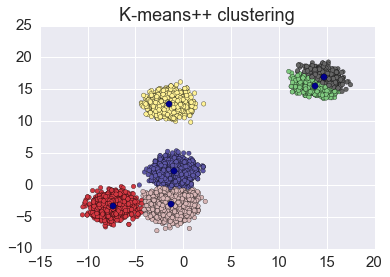

In [135]:
plt.figure()
plt.scatter(sim_data_k4[:,0], sim_data_k4[:,1], c=labels_para, cmap='Accent')
plt.scatter(x_para, y_para, s=40, marker="o", c="darkblue")
plt.title("K-means++ clustering")
pass